## Imports

In [59]:
import cv2 as cv
import numpy as np
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import adam_v2
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('fivethirtyeight')


## Test GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


## Prepare data

## Import train and test data

In [149]:
train_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/real-pokedex/dataset/train/'
test_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/real-pokedex/dataset/test/'
val_split = 0.3
num_pokemons = len(os.listdir(train_dir))

X_train = []
y_train = []

p = 0
for pokedir in os.listdir(train_dir):
    for pokemon in os.listdir(train_dir+pokedir+'/')[:40]:
        imgdata = cv.imread(train_dir+pokedir+'/'+pokemon)
        imgdata = cv.resize(imgdata, (32, 32),0,0,cv.INTER_LINEAR)
        X_train.append(imgdata)
        y_train.append(p)
    p += 1
X_train = np.array(X_train).reshape((len(X_train), 32, 32, 3))
y_train = np.array(y_train).reshape((len(y_train),1))


X_test = []
y_test = []

p = 0
for pokedir in os.listdir(test_dir):
    for pokemon in os.listdir(test_dir+pokedir+'/')[:20]:
        imgdata = cv.imread(test_dir+pokedir+'/'+pokemon)
        imgdata = cv.resize(imgdata, (32, 32),0,0,cv.INTER_LINEAR)
        X_test.append(imgdata)
        y_test.append(p)
    p += 1
X_test = np.array(X_test).reshape((len(X_test), 32, 32, 3))
y_test = np.array(y_test).reshape((len(y_test),1))

X_train = X_train/255.0
X_test = X_test/255.0

y_train = to_categorical(y_train, num_classes=166)
y_test = to_categorical(y_test, num_classes=166)


## Import data using `ImageDataGenerator`

In [112]:
datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('dataset/train/', batch_size=batch_size, target_size=(32,32))
test_it = datagen.flow_from_directory('dataset/test/', batch_size=batch_size, target_size=(32, 32))
X_train, y_train = train_it.next()
X_test, y_test = test_it.next()
print(X_train.shape)
print(X_test.shape)
# model.fit_generator(train_it, epochs = num_epochs, steps_per_epoch=16, validation_data=test_it, validation_steps=8)

Found 33358 images belonging to 166 classes.
Found 7396 images belonging to 166 classes.
(512, 32, 32, 3)
(512, 32, 32, 3)


# Setup and train model

In [157]:
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(32,32,3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_pokemons, activation = 'softmax'))

lr = 1e-4

opt = adam_v2.Adam(learning_rate=lr)

model.compile(
            loss= 'categorical_crossentropy', \
            optimizer= opt, \
            metrics = ['accuracy']
            )

num_epochs = 100
batch_size = 128
hist = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose=0, validation_split = 0.5)
# save the model
# model.save('pokedex.model')

## Plot loss and accuracy

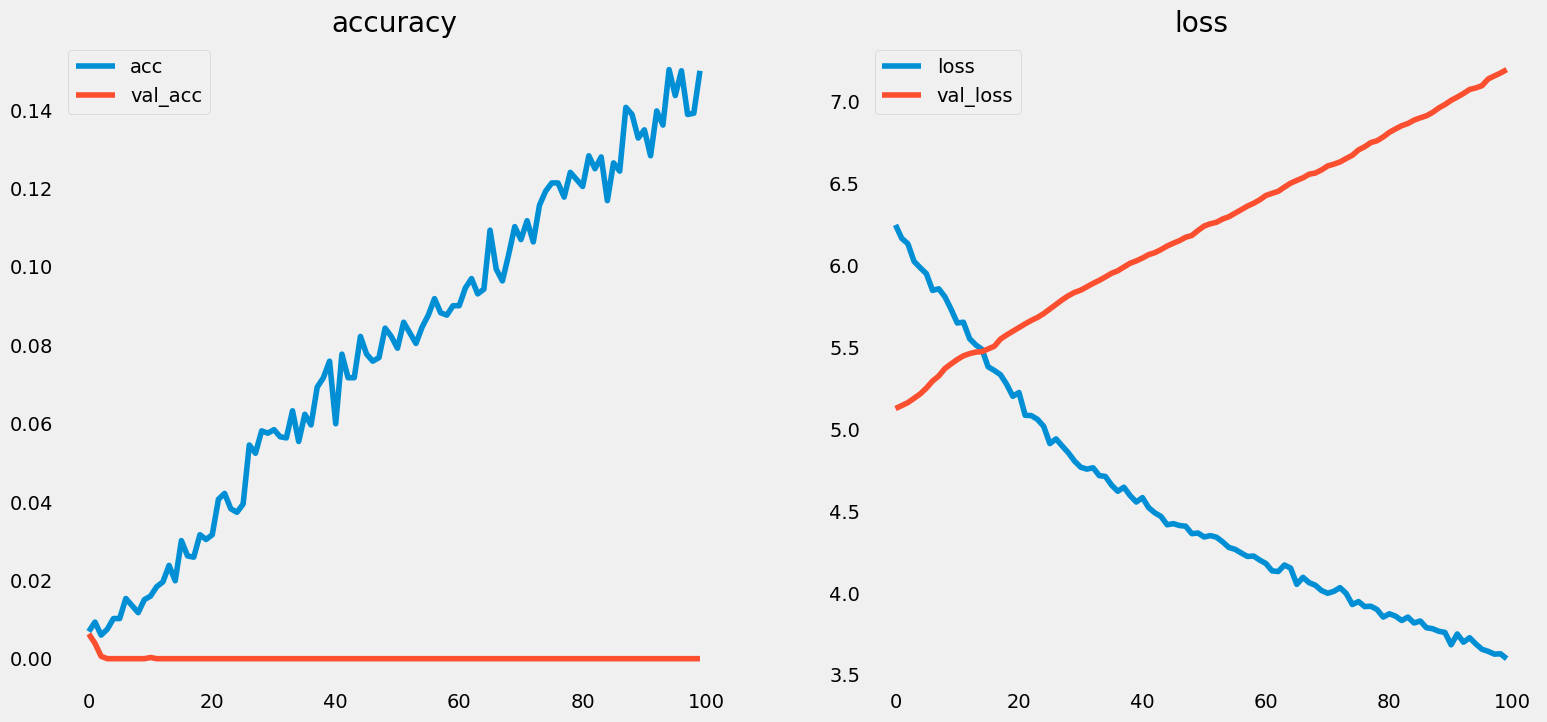

In [158]:
# Plot learning curves
fig = plt.figure(figsize = (17, 8))
    
plt.subplot(121)
plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

plt.show()

## Test model

Predicted index: 141
Predicted should match label: 326


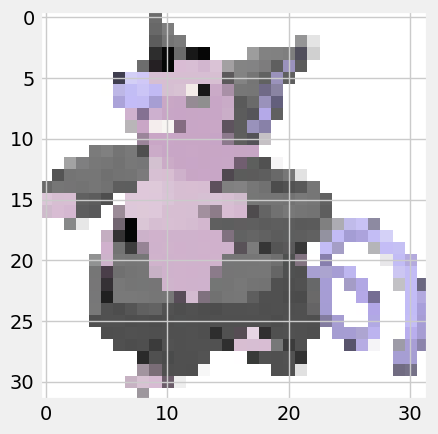

In [84]:
pred = model.predict(X_test)
index = 60 #the index you want to test
result = np.argmax(pred[index])
result_class = classes[result]
print("Predicted index: %d" % np.argmax(pred[index]))
print("Predicted should match label: %d" %(np.where(y_test[index]==1)[0]+1))
plt.imshow(X_test[index], interpolation='nearest')
plt.show()

In [90]:
model.evaluate(X_test, y_test, verbose=0)

[7.102900981903076, 0.0]